In [82]:
%pip install matplotlib pandas numpy seaborn scikit-learn xgboost whois

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\orsin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [83]:
import pandas as pd
import random

# Define the paths to the CSV files
legit_urls_path = 'resources/legit_urls.csv'
phishing_urls_path = 'resources/phishing_urls.csv'

# Read the CSV files
legit_urls_df = pd.read_csv(legit_urls_path, header=None, names=['url']) #no header given in this csv file. so custom naming
phishing_urls_df = pd.read_csv(phishing_urls_path)

In [84]:
legit_urls_df.head()

,url
0,http://1337x.to/torrent/1048648/American-Snipe...
1,http://1337x.to/torrent/1110018/Blackhat-2015-...
2,http://1337x.to/torrent/1122940/Blackhat-2015-...
3,http://1337x.to/torrent/1124395/Fast-and-Furio...
4,http://1337x.to/torrent/1145504/Avengers-Age-o...


In [85]:
phishing_urls_df.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,6557033,http://u1047531.cp.regruhosting.ru/acces-inges...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T22:01:43+00:00,yes,2020-05-09T22:03:07+00:00,yes,Other
1,6557032,http://hoysalacreations.com/wp-content/plugins...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T22:01:37+00:00,yes,2020-05-09T22:03:07+00:00,yes,Other
2,6557011,http://www.accsystemprblemhelp.site/checkpoint...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T21:54:31+00:00,yes,2020-05-09T21:55:38+00:00,yes,Facebook
3,6557010,http://www.accsystemprblemhelp.site/login_atte...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T21:53:48+00:00,yes,2020-05-09T21:54:34+00:00,yes,Facebook
4,6557009,https://firebasestorage.googleapis.com/v0/b/so...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T21:49:27+00:00,yes,2020-05-09T21:51:24+00:00,yes,Microsoft


In [86]:
# Take random samples of 5000 URLs from each dataframe
random.seed(42)  # For reproducibility - every time random is run, u get the same result
legit_sample = legit_urls_df.sample(n=5000, random_state=42)
phishing_sample = phishing_urls_df.sample(n=5000, random_state=42)

# Create new dataframes with only the 'url' column (all uppercase)
legit_df = pd.DataFrame(data={'URL': legit_sample['url']})   # 'URL' is the name of column and column is the url column
phishing_df = pd.DataFrame(data={'URL': phishing_sample.iloc[:, 1]})  # index 1 (2nd column) and name='URL'

In [87]:
# Reset index for legit_sample dataframe
legit_df.reset_index(drop=True, inplace=True)
# drop=true means i dont't want the old index as a separate column and inplace=true returns none and modifies in place
# Reset index for phishing_sample dataframe
phishing_df.reset_index(drop=True, inplace=True)

In [88]:
legit_df.head()

,URL
0,http://codecanyon.net/search?date=this-month&l...
1,http://caixa.gov.br/empresa/credito-financiame...
2,http://olx.ua/uk/list/q-%D0%B4%D0%B6%D0%B8%D0%...
3,http://elitedaily.com/wp-content/themes/strang...
4,http://metro.co.uk/2014/10/10/is-big-brother-f...


In [89]:
phishing_df.head()

,URL
0,https://iptf.ir/.well-known/acme-challenge/cha...
1,https://lynshirt.com/wp-admin/PayPal/customer_...
2,https://hotdealsaz.com/Secure/inline.php
3,http://lz5.1ee.myftpupload.com/mvc/b105e5a192f...
4,http://claassistencia.com.br/wp-admin/includes...


 # Feature Extraction (1 for Phishing | 0 for legit )

## 1. Address Bar Based Features

In [90]:
from urllib.parse import urlparse,urlencode
import ipaddress
import re

### 1.1 Get Domain (gets the domain after removing www.) - Not used for training

In [91]:
def getDomain(url):  
  domain = urlparse(url).netloc   #get the network location (domain)
  if re.match(r"^www.",domain):   # ^ ensures www is at start and . ensures some char is after www
       domain = domain.replace("www.","")   #remove www. if found
  return domain

### 1.2 IP address - if IP address instead of domain, then phishing

In [92]:
def havingIP(url):
  try:
    ipaddress.ip_address(url)
    ip = 1
  except:
    ip = 0
  return ip

### 1.3 if @ in URL , then phishing (browser ignores everything before it and goes to fake website after it)

In [93]:
def haveAtSign(url):
  if "@" in url:
    at = 1    
  else:
    at = 0    
  return at

### 1.4 if length>=54 , phishing as real address hidden inside it

In [94]:
def getLength(url):
  if len(url) < 54:
    length = 0            
  else:
    length = 1            
  return length

### 1.5 Gets the depth of url (number of subpages : number of non empty parts after splitting with / )

In [95]:
def getDepth(url):
  s = urlparse(url).path.split('/')
  depth = 0
  for j in range(len(s)):
    if len(s[j]) != 0:
      depth = depth+1
  return depth

### 1.6 If position of // (for redirection) is anything other than 6 (http) or 7 (https) - then phishing

In [96]:
def redirection(url):
  pos = url.rfind('//')
  if pos > 6:
    if pos > 7:
      return 1
    else:
      return 0
  else:
    return 0

### 1.7 If HTTP/HTTPS found in domain, then phishing

In [97]:
def httpDomain(url):
  domain = urlparse(url).netloc
  if 'https' in domain:
    return 1
  else:
    return 0

### 1.8 If URL uses shortener (short url leads to required webpage using HTTP redirect) , then phishing

In [98]:
#listing shortening services
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"    # \. means . (escape character) and | means or

In [99]:
def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
        return 1
    else:
        return 0

### 1.9 If - found in domain of URL , then phishing

In [100]:
def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 1            
    else:
        return 0            

### 1.10 Domain Age : Phishing sites tipically have recent domain age, using socket I'll be able to check domain ages

In [101]:
import whois
from datetime import datetime

def domainAge(url):
    try:
        domain = urlparse(url).netloc
        whois_info = whois.whois(domain)
        creation_date = whois_info.creation_date
        
        # If multiple creation dates exist, take the first one
        if isinstance(creation_date, list):
            creation_date = creation_date[0]
        
        age = (datetime.now() - creation_date).days
        return 0 if age >= 180 else 1  # If the domain is less than 6 months old, it is suspicious
    except:
        return 1  # If the domain is not found, it is considered suspicious


# MAKING THE DATAFRAME

In [102]:
def featureExtraction(url,label):
  features = []

  #Address bar based features 
  features.append(getDomain(url))
  features.append(havingIP(url))
  features.append(haveAtSign(url))
  features.append(getLength(url))
  features.append(getDepth(url))
  features.append(redirection(url))
  features.append(httpDomain(url))
  features.append(tinyURL(url))
  features.append(prefixSuffix(url))
  features.append(domainAge(url))

  features.append(label)
  
  return features

## LEGIT

In [103]:
from tqdm.notebook import tqdm

In [104]:
legi_features = []
label = 0  # for legit, label will be 0

for i in tqdm(range(0, 5000)):
  url = legit_df['URL'][i]
  legi_features.append(featureExtraction(url,label))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [105]:
feature_names = ['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection', 
                      'https_Domain', 'TinyURL', 'Prefix/Suffix','Domain_Age','Label']

legitimate = pd.DataFrame(legi_features, columns= feature_names)
legitimate.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Domain_Age,Label
0,codecanyon.net,0,0,1,1,0,0,0,0,1,0
1,caixa.gov.br,0,0,1,4,0,0,0,0,1,0
2,olx.ua,0,0,1,4,0,0,0,0,1,0
3,elitedaily.com,0,0,1,5,0,0,0,0,1,0
4,metro.co.uk,0,0,1,4,0,0,0,0,1,0


## PHISHING

In [106]:
phish_features = []
label = 1
for i in tqdm(range(0, 5000)):
  url = phishing_df['URL'][i]
  phish_features.append(featureExtraction(url,label))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [107]:
feature_names = ['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection', 
                      'https_Domain', 'TinyURL', 'Prefix/Suffix','Domain_Age','Label']

phishing = pd.DataFrame(phish_features, columns= feature_names)
phishing.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Domain_Age,Label
0,iptf.ir,0,0,1,4,0,0,0,0,1,1
1,lynshirt.com,0,0,1,6,0,0,1,0,1,1
2,hotdealsaz.com,0,0,0,2,0,0,0,0,1,1
3,lz5.1ee.myftpupload.com,0,0,1,2,0,0,0,0,1,1
4,claassistencia.com.br,0,0,1,3,0,0,0,0,1,1


## COMBINING

In [108]:
urldata = pd.concat([legitimate, phishing]).reset_index(drop=True)
urldata.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Domain_Age,Label
0,codecanyon.net,0,0,1,1,0,0,0,0,1,0
1,caixa.gov.br,0,0,1,4,0,0,0,0,1,0
2,olx.ua,0,0,1,4,0,0,0,0,1,0
3,elitedaily.com,0,0,1,5,0,0,0,0,1,0
4,metro.co.uk,0,0,1,4,0,0,0,0,1,0


In [109]:
urldata.tail()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Domain_Age,Label
9995,team.cmgcharleston.com,0,0,1,8,0,0,0,0,1,1
9996,clubeamigosdopedrosegundo.com.br,0,0,0,1,0,0,0,0,1,1
9997,ebaymessage.gvnawpknwarz94ejtnbuvbwv.xyz,0,0,1,2,0,0,0,0,1,1
9998,dongsuh.net,0,0,1,2,0,0,0,0,1,1
9999,c1800258.ferozo.com,0,0,0,3,0,0,0,0,1,1


In [110]:
data = urldata.drop(['Domain'], axis = 1).copy()   #drops the domain along axis=1 (column) and assigns its deep copy to data

In [111]:
data = data.sample(frac=1).reset_index(drop=True)  #data.sample shuffles rows, frac=1 means shuffle all rows and reset the index
data.head()

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Domain_Age,Label
0,0,0,1,3,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,1
2,0,0,1,4,0,0,0,0,1,0
3,0,0,1,5,0,0,0,0,1,0
4,0,0,1,3,0,0,0,0,1,0


# MAKING THE MODEL

In [112]:
y = data['Label']
X = data.drop('Label',axis=1)
X.shape, y.shape

((10000, 9), (10000,))

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 12)
X_train.shape, X_test.shape

((8000, 9), (2000, 9))

In [114]:
from sklearn.metrics import accuracy_score

# XGBoost  

In [115]:
#XGBoost Classification model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier(learning_rate=0.4,max_depth=7)   
#sets the learning rate/gradient - more is faster but overfitting
#sets the max depth of individual trees as 7. more allows complex patterns but may overfit
#fit the model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [116]:
y_test_xgb = xgb.predict(X_test)
y_train_xgb = xgb.predict(X_train)

In [117]:
acc_train_xgb = accuracy_score(y_train,y_train_xgb)
acc_test_xgb = accuracy_score(y_test,y_test_xgb)

print("XGBoost: Accuracy on training Data: {:.3f}".format(acc_train_xgb))
print("XGBoost : Accuracy on test Data: {:.3f}".format(acc_test_xgb))

XGBoost: Accuracy on training Data: 0.818
XGBoost : Accuracy on test Data: 0.812


# Random Forest

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # number of trees
    max_depth=10,      # maximum depth of trees
    random_state=42    # for reproducibility
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, rf_predictions))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 5 Most Important Features:")
print(feature_importance.head(5))

Random Forest Accuracy: 0.8115

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1007
           1       0.86      0.74      0.79       993

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000


Top 5 Most Important Features:
         feature  importance
2     URL_Length    0.555343
3      URL_Depth    0.217110
7  Prefix/Suffix    0.170120
1        Have_At    0.042918
6        TinyURL    0.009097


### Hyperparameters tuning for Random Forest

In [119]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
rf_grid.fit(X_train, y_train)

print("Best parameters:", rf_grid.best_params_)
print("Best score:", rf_grid.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.8171250000000001


### Creating Random Forest model optimized with the right parameters

In [120]:
# Create the Random Forest with best parameters
best_rf = RandomForestClassifier(**rf_grid.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [121]:
# Make predictions and evaluate
y_pred = best_rf.predict(X_test)
y_pred_prob = best_rf.predict_proba(X_test)

# Calculate various metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_prob[:, 1])
}

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.8115
Precision: 0.8641
Recall: 0.7362
F1 Score: 0.7950
ROC AUC: 0.8712


### Visualizing the results

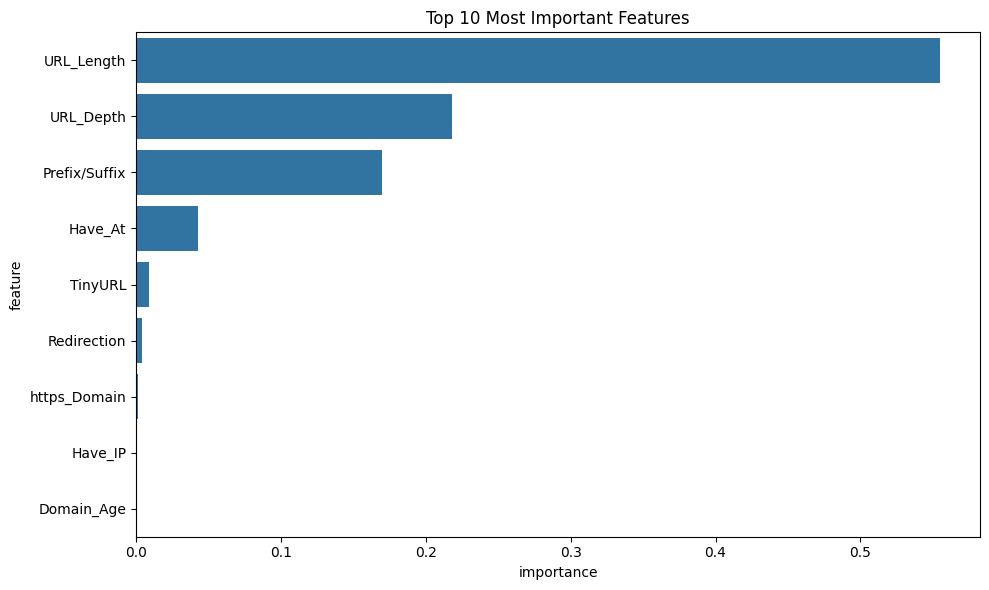

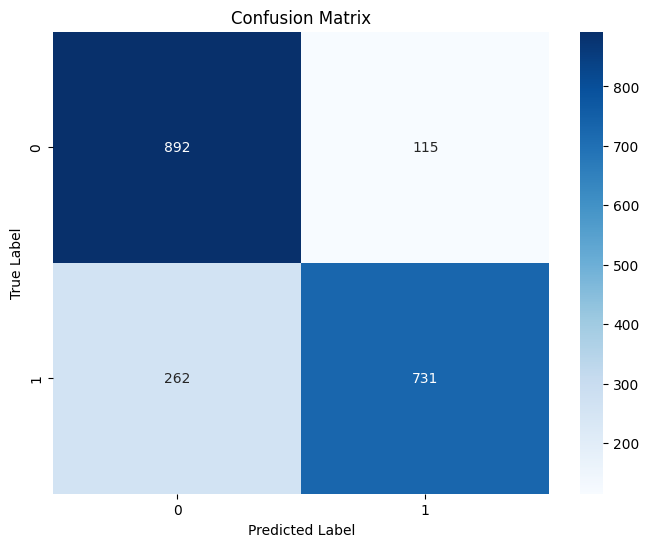

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SVM

Starting Grid Search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.780 total time=   3.2s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.787 total time=   3.1s
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.787 total time=   3.2s
[CV 4/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.821 total time=   3.1s
[CV 5/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.818 total time=   3.3s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.780 total time=   3.3s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.787 total time=   3.1s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.781 total time=   3.4s
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.808 total time=   3.5s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.807 total time=   3.5s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.783 total time=   3.3s
[CV 2/5] END .......C=1, 

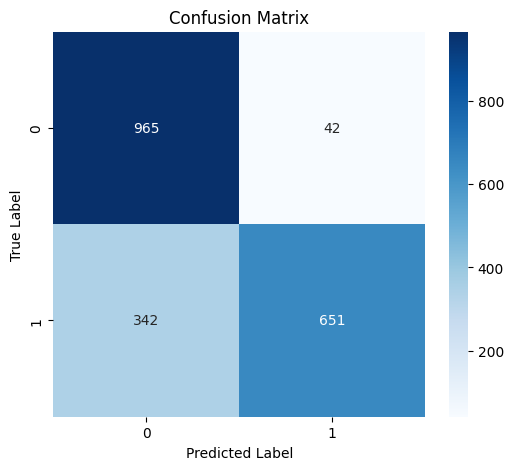

In [129]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a reduced parameter grid (to speed up search)
param_grid = {
    'C': [1, 10, 100],  # Removed 0.1 for faster search
    'gamma': ['scale', 0.1, 0.01],  # Removed 'auto'
    'kernel': ['rbf']  # Only RBF kernel
}

# Start GridSearch
print("Starting Grid Search...")
start_time = time.time()

grid_search = GridSearchCV(
    estimator=SVC(random_state=42, probability=True),
    param_grid=param_grid,
    cv=5,
    n_jobs=1,  # Avoid parallel execution issues
    verbose=3  # Show detailed progress
)

grid_search.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"\nGrid Search completed in {end_time - start_time:.2f} seconds")

# Get best parameters
best_params = grid_search.best_params_
print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-validation Score: {grid_search.best_score_:.4f}")

# Train the best model
best_svm = SVC(**grid_search.best_params_, random_state=42, probability=True)
best_svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_svm.predict(X_test_scaled)
y_pred_prob = best_svm.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for ROC AUC

# Compute accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob) if len(set(y_test)) == 2 else None

print(f"\nAccuracy: {accuracy:.4f}")
if roc_auc is not None:
    print(f"ROC AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
def testing(url):
  features = []

  #Address bar based features 
  features.append(havingIP(url))
  features.append(haveAtSign(url))
  features.append(getLength(url))
  features.append(getDepth(url))
  features.append(redirection(url))
  features.append(httpDomain(url))
  features.append(tinyURL(url))
  features.append(prefixSuffix(url))
  features.append(domainAge(url))
    
  return [features]     #dont add label here and give back a 2d array 

In [ ]:
arr = testing('http://grantland.com/features/mlb-the-30-red-sox-yankees-blue-jays-orioles-al-east/')
val = xgb.predict(arr)
if val==0:
    print("SAFE")
else:
    print("PHISHING")

SAFE


# SAVING THE MODEL

In [ ]:
import pickle
pickle.dump(xgb, open("XGBoostClassifier.pickle.dat", "wb"))

In [ ]:
loaded_model = pickle.load(open("XGBoostClassifier.pickle.dat", "rb"))
loaded_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# TODO : TUNING HYPERPARAMETRI

# Metriche di Valutazione per Modelli di Classificazione

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, roc_curve, auc,
                           precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_test, y_test):
    # Predizioni
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metriche base
    print("Basic Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()